<a href="https://colab.research.google.com/github/mgt412/course_notebooks/blob/master/MGT412_Lecture_7_PortfolioTheory_EfficientFrontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 7: Portfolio Theory and the Efficient Frontier. Normality of Returns.

In [0]:
import numpy as np
import numpy.random as npr
from pandas import *
import matplotlib.pyplot as plt
import scipy.optimize as sco
%matplotlib inline

### Loading data for portfolio analysis

Load daily closing prices on five stocks: Apple, Microsoft, Yahoo, Deutsche Bank, and Goldman Sachs.

In [3]:
path="https://github.com/mgt412/course_notebooks/blob/master/Datasets/L7_PortfolioData.xlsx?raw=true"
data=read_excel(path)
data.head()

,Date,AAPL,MSFT,YHOO,DB,GLD
0,2010-01-04,28.588685,26.593966,17.100000,61.392277,109.800003
1,2010-01-05,28.638111,26.602557,17.230000,62.565957,109.699997
2,2010-01-06,28.182584,26.439299,17.170000,61.484485,111.510002
3,2010-01-07,28.130486,26.164338,16.700001,62.180321,110.820000
4,2010-01-08,28.317506,26.344781,16.700001,64.427088,111.370003


In [4]:
if data.index.name=='Date':
    returns=np.log(data/data.shift(1)).reset_index()
else:
    data=data.set_index('Date')
    returns=np.log(data/data.shift(1)).reset_index() # compute log-returns

no_assets=len(returns.columns.tolist())-1
print "No assets=", no_assets
returns.head()

No assets= 5


,Date,AAPL,MSFT,YHOO,DB,GLD
0,2010-01-04,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,0.001727,0.000323,0.007574,0.018937,-0.000911
2,2010-01-06,-0.016034,-0.006156,-0.003488,-0.017436,0.016365
3,2010-01-07,-0.001850,-0.010454,-0.027755,0.011254,-0.006207
4,2010-01-08,0.006626,0.006873,0.000000,0.035496,0.004951


## Monte Carlo portfolios

We want to plot various portfolios of the five stocks (i.e., each portfolio will use different weights $w$) in the expected return-volatility space. Let us simulate N = 1000 portfolios.

Expected returns and volatility of portfolio $i$:

\begin{align*}
\mathbb{E}R_{i}&=w_{i,j}^T \times \mathbb{E}R_{j} \\
\sigma^2_{i}&=w^{T}_{i,j} \times \text{cov}\left(R_{j}\right) \times w_{i,j}
\end{align*}

In [0]:
MC_returns=[] # return vector
MC_vols=[] # volatility vector
N=1000 # number of portfolios

for p in range(N):
    weights=np.random.rand(no_assets) # random weights
    weights/= np.sum(weights) # normalize weights to make sure they add up to one.
    MC_returns.append(np.sum(returns.mean()*weights)*252) # compute expected returns (annual)
    MC_vols.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))) # compute volatility (annual)
MC_returns=np.array(MC_returns)
MC_vols=np.array(MC_vols)

We plot the portfolios:

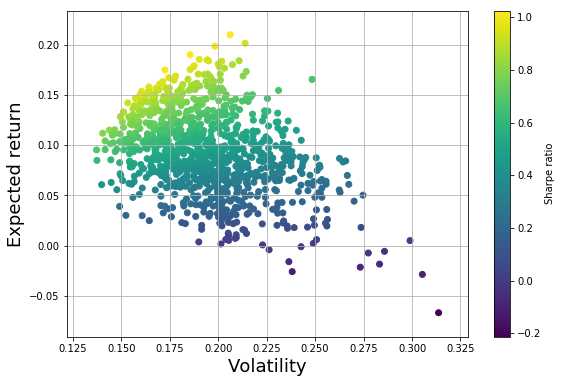

In [6]:
plt.figure(figsize=(9,6))
plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)
plt.colorbar(label='Sharpe ratio')

### Portfolio summary measures

Build a function that, for a given vector of portfolio weights $w$, it returns the portfolio’s expected return, volatility, and the Sharpe
ratio (as a vector).

In [0]:
def portfolio(weights):
    weights=np.array(weights)
    P_ret=np.sum(returns.mean()*weights)*252
    P_vol=np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    return np.array([P_ret,P_vol, P_ret/P_vol])

### Maximum Sharpe Ratio portfolio

1. Define a function for the negative Sharpe ratio (we want to maximise it).
2. Set up the constraint that portfolio weights add up to one.
3. Set up boundaries for the portfolio weights (between 0 and 1).

In [9]:
def Sharpe(weights):
    return -portfolio(weights)[2]

cons=({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds=tuple((0,1) for x in range(no_assets))

opt_S=sco.minimize(Sharpe, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)

print opt_S['x'].round(3) # weights

portfolio(opt_S['x']) # statistics

[0.662 0.086 0.252 0.    0.   ]


array([0.23603956, 0.22204861, 1.06300848])

### Minimum variance portfolio

1. Define a function for the portfolio variance
2. Set up the constraint that portfolio weights add up to one.
3. Set up boundaries for the portfolio weights (between 0 and 1).

In [0]:
def Variance(weights):
    return portfolio(weights)[1]**2

opt_V=sco.minimize(Variance, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)

print opt_V['x'].round(3) # weights
portfolio(opt_V['x']) # statistics

[ 0.108  0.249  0.109  0.     0.534]


array([ 0.08726149,  0.13523313,  0.64526711])

## Plotting the efficient frontier

**Problem.**  Minimise variance of a portfolio
\begin{equation}
\min_{w_i} w_i^T \Sigma w_i
\end{equation}
subject to a target return:
\begin{equation}
w_i^T R = R_\text{target}
\end{equation}


1. We solve this problem for many levels of the target return.
2. Each time we do, we get another point on the efficient frontier.
3. We need to specify the constraint in a loop, as the target return is always changing.


**Algorithm.** 
1. Define a range for target returns.
2. Define an (empty) vector for the corresponding minimum volatilities.
3. In a loop of target returns, minimise variance under the constraint that the portfolio return equals the target return.

In [0]:
TargetRet=np.linspace(0.0,0.25,50) # range for target returns
MinVols=[]

for tret in TargetRet:
    cons=({'type':'eq', 'fun':lambda x: portfolio(x)[0]-tret},{'type':'eq', 'fun':lambda x: np.sum(x)-1})
    res=sco.minimize(lambda x: portfolio(x)[1], no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)
    MinVols.append(res['fun'])

Text(0,0.5,'Expected return')

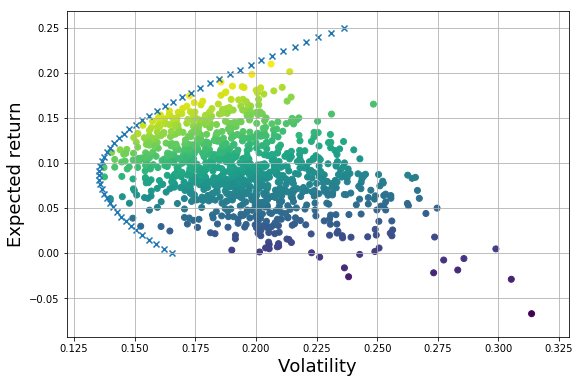

In [11]:
plt.figure(figsize=(9,6))
plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.scatter(MinVols, TargetRet, marker='x')
plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)

## Plotting the Capital Market Line (CML)

1. Let the risk-free rate, rf = 1%.
2. The CML is a straight line starting from the risk-free rate and tangent to the upper part of the efficient frontier.
3. We do not have a closed form for the efficient frontier, so we need to use interpolation.

**Efficient frontier (non-dominated)**
* The trick is to remember that the return vector is sorted in ascending order.
* Portfolios with returns above the minimum variance portfolio are non-dominated!

In [0]:
import scipy.interpolate as sci # we will use interpolation

1. Let $t(x)=a+b\times x$ be the linear CML.
2. Let $f(x)$ be the efficient frontier EF.
3. Let $x^\star$ be the tangency portfolio.

At the tangency portfolio, CML and EF have:
1. equal values $t(x^\star)=f(x^\star)$
2. equal first derivatives $t^\prime(x^\star)=f^\prime(x^\star)$

### Numerical interpolation of the efficient frontier and its slope

We create numerical approximation via interpolation of
1. the efficient frontier
2. its first derivative

In [0]:
ind=np.argmin(MinVols) # minimum variance portfolio index

erets=TargetRet[ind:] # all portfolios on the "positive" side of EF
evols=MinVols[ind:]

tck=sci.splrep(evols,erets) # interpolate a spline

def f(x): # evaluate the spline
    return sci.splev(x,tck,der=0)
def df(x): # evaluate the first derivative of the spline
    return sci.splev(x,tck,der=1)

### Equations for CML 

1. We define a function to solve the system of equations.
2. The input is a vector containing
> * the risk-free rate (CML intercept)
>*  the maximum Sharpe ratio (CML slope)
>*  the tangency portfolio variance.
3. The output is the value of the three equations in the system.
**For the tangency portfolio, they should all be zero!**


1. Find some plausible starting values for the solver (eye-balling, intuition...)
2. Use the fsolve function to find the CML.

In [0]:
def equations(p, rf=0.01):
    eq1=rf-p[0] # CML starts at RF rate
    eq2=rf+p[1]*p[2]-f(p[2]) # RF rate + slope * tangency vol = EF at tangency vol
    eq3=p[1]-df(p[2]) # CML slope = EF slope at tangency vol
    return eq1, eq2, eq3

opt=sco.fsolve(equations, [0.01, 0.5, 0.15])

We now have the linear CML function:
1. `opt[0]` is the risk-free rate.
2. `opt[1]` is the maximum Sharpe ratio.

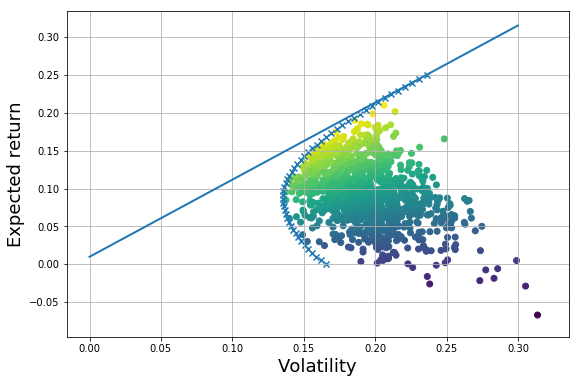

In [15]:
plt.figure(figsize=(9,6))
plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.scatter(MinVols, TargetRet, marker='x')
plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)
cx=np.linspace(0.0,0.3)
plt.plot(cx, opt[0]+opt[1]*cx, lw=2)

## Tests for data normality

Many influential theories in finance assume the normality of stock returns:
1. *Portfolio theory and CAPM*: Normality of returns implies that only the mean and variance are relevant for portfolio optimization.
2. *Option pricing theory*: The Black and Scholes model, and many other pricing models assume (log-)returns follow a Brownian motion, i.e., are normally distributed over any given time interval.

Is normality a realistic assumption? How to test for it?

### Benchmark: Simulated data

Let us simulate 10,000 stock price paths from a Geometric Brownian motion, and save the log returns.

In [0]:
def gen_paths(S0,r,sigma, T,M,I):

    dt=float(T)/M
    paths=np.zeros((M+1,I))
    paths[0]=S0
    for t in range(1,M+1):
        rand=np.random.randn(I)
        paths[t]=paths[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*rand)
    return paths

paths=gen_paths(100,0.05,0.2,1.0,50,10000)
log_returns=np.log(paths[1:]/paths[0:-1])

#### Plot a histogram (does it have a bell shape?)

Text(0.5,0,'Simulated return')

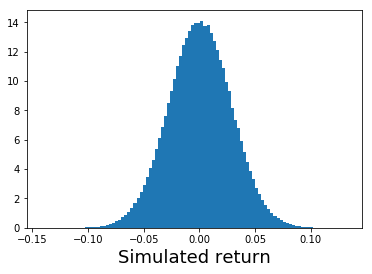

In [44]:
plt.hist(log_returns.flatten(),bins=100, density=True)
plt.xlabel("Simulated return", fontsize=18)

#### Plot a quantile-quantile plot: if normal, it should look like a straight line!

Text(0.5,0,'Sample quantiles')

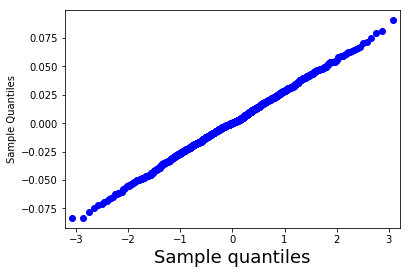

In [45]:
import statsmodels.api as sm
sm.qqplot(log_returns.flatten()[:1000])
plt.xlabel("Theoretical quantiles", fontsize=18)
plt.xlabel("Sample quantiles", fontsize=18)

In [46]:
# Testing for skewness, kurtosis, and normality

# Skewness = returns are not "symmetrically distributed" 
#           (more likely to be negative or positive)
# Kurtosis = large returns in absolute value are more likely than the normal
#            distribution would allow (fat tails)

import scipy.stats as scs
print (scs.skew(log_returns.flatten()), scs.skewtest(log_returns.flatten()))
print (scs.kurtosis(log_returns.flatten()), scs.kurtosistest(log_returns.flatten()))
print (scs.normaltest(log_returns.flatten()))

(0.00029689241987615656, SkewtestResult(statistic=0.0857067429148621, pvalue=0.9316995417844929))
(0.005084849299667127, KurtosistestResult(statistic=0.7372857414773093, pvalue=0.4609486013061892))
NormaltestResult(statistic=0.55093591036682, pvalue=0.7592167606660922)


## S&P/TSX

In [0]:
url="https://github.com/mgt412/course_notebooks/blob/master/Datasets/L5_SPTSX_Prices.xlsx?raw=true"
SPTSX=read_excel(url)
# clean the data
SPTSX=SPTSX.replace("null",np.nan)
SPTSX=SPTSX.fillna(method='ffill')

In [0]:
log_spreturns=np.asarray(np.log(SPTSX['SPTSX']/SPTSX['SPTSX'].shift(1)).tolist())

Text(0.5,0,'S&P/TSX return')

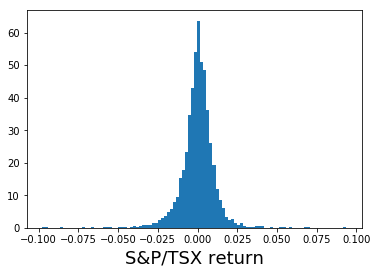

In [49]:
plt.hist(log_spreturns[1:],bins=100,normed=True)
plt.xlabel("S&P/TSX return", fontsize=18)

Text(0.5,0,'S&P/TSX return quantiles')

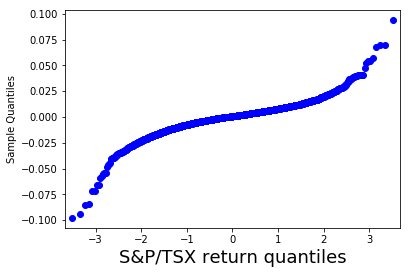

In [50]:
sm.qqplot(log_spreturns[1:])
plt.xlabel("Theoretical quantiles", fontsize=18)
plt.xlabel("S&P/TSX return quantiles", fontsize=18)

In [51]:
print scs.skew(log_spreturns[1:]), scs.skewtest(log_spreturns[1:])
print scs.kurtosis(log_spreturns[1:]), scs.kurtosistest(log_spreturns[1:])
print scs.normaltest(log_spreturns[1:])

-0.706517964315 SkewtestResult(statistic=-18.138754798113563, pvalue=1.575606377456521e-73)
10.9823643774 KurtosistestResult(statistic=29.876565461052927, pvalue=3.967409647633784e-196)
NormaltestResult(statistic=1221.6235893746684, pvalue=5.343281883311205e-266)
